In [1]:
!pip install torchmetrics

In [2]:
import pandas as pd
from sklearn import utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torchvision import datasets
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader
import numpy as np
import csv
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics import classification


In [3]:
data = pd.read_csv('/content/drive/MyDrive/dennis_ocr/archive/mnistA-Z0-9.csv').astype('float32')


In [4]:

def get_train_test(data):

  data.rename(columns={'0':'label'}, inplace=True)

  X = data.drop('label', axis = 1)
  y = data['label']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [5]:
def get_class_weights(y):

  weights = compute_class_weight(class_weight = 'balanced', classes = y.value_counts().index, y = y)

  return weights


In [6]:
def display(data, labels):

  #X, y = utils.shuffle(data, labels)

  plt.figure(figsize=(9,9))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.imshow(X.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
    ax.title.set_text(y[i])

  plt.show()


In [10]:
def show_img(img, label):
  plt.figure(figsize=(3,3))

  ax = plt.imshow(img.values.reshape(28,28),interpolation='nearest', cmap='Greys')
  print(label)

  plt.show()

In [6]:
class Digits(Dataset):

  def __init__(self, X, y, transform = None):
    self.X = np.asarray(X)
    self.X = self.X.reshape(self.X.shape[0], 28, 28).astype('float32')
    #print(self.X.shape)
    #print(self.X[0].shape)
    self.X = torch.from_numpy(self.X).float()
    self.y = np.asarray(y)
    self.y = torch.from_numpy(self.y).long()
    self.transform = transform


  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    target = self.X[index]
    #print(target.shape)
    target.unsqueeze_(0)
    target.repeat(3, 1, 1)
    label = self.y[index]
    if self.transform:
      target = self.transform(target)
    return target, label



In [7]:
train_transform = v2.Compose([
        v2.Resize((32, 32)),
        v2.RandomRotation(10),
        v2.RandomZoomOut( p = 0.2),
        #v2.Random
        v2.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
        #v2.ToTensor(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale = True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [8]:
test_transform = v2.Compose([
    v2.Resize((32, 32)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:

training = Digits(X_train, y_train, transform = train_transform)
testing = Digits(X_test, y_test, transform = test_transform)


In [10]:

train_dataloader = DataLoader(training, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testing, batch_size=32, shuffle=True)

In [11]:

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )



In [12]:



def calculate_accuracy(output, target):
    predictions = torch.argmax(torch.softmax(output, dim = 1, dtype = None), dim = 1)
    predictions = predictions.cpu().numpy()
    target = target.cpu().numpy()

    return (np.sum(target == predictions)/len(predictions))

def train(train_loader, model, criterion, optimizer, epoch, params, train_accs):
    torch.set_default_dtype(torch.float32)
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    temp_accs = []
    for i, (images, target) in enumerate(stream, start=1):
        #images = images.to(params["device"], non_blocking=True).float()
        images = images.to(params["device"], non_blocking=True)
        #target = target.to(params["device"], non_blocking=True).float().view(-1, 1)

        #target = target.to(params["device"], non_blocking=True).float()
        target = target.to(params["device"], non_blocking=True).float()
        #print(target.long())
        #print(images.shape)
        output = model(images)
        #print(output.shape)
        #print(images)
        #loss = criterion(output, target.long())
        #type(target)
        #target = target.type(torch.LongTensor)
        type(target)
        loss = criterion(output, target.long())
        accuracy = calculate_accuracy(output, target)
        temp_accs.append(accuracy)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

    train_accs.append(np.mean(temp_accs))

In [13]:
params = {
    "model": "resnet50",
    #"device": "cuda", # for GPU
    "device": "cpu", # for CPU
    "lr": 0.0001,
    "batch_size": 128,
    "num_workers": 0,
    "epochs": 10,
}

In [15]:
def save_model(model):
  torch.save(model.state_dict(), '/content/drive/MyDrive/dennis_ocr/ocr.pt')


In [14]:
model = getattr(models, params["model"])(pretrained=False, num_classes=36,)
model = model.to(params["device"])

criterion = nn.CrossEntropyLoss(weight = torch.from_numpy(get_class_weights(y_test)).float()).to(params["device"])
#criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=1e-5)


#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
torch.set_default_dtype(torch.float32)

train_accs = []

for i in range(params['epochs']):
  train(train_dataloader,  model, criterion, optimizer, i, params, train_accs)
  if train_accs[i] > 0.95 or i == (params['epochs'] - 1):
    save_model(model)
    break

  0%|          | 0/3111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(27, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 0. Train.      Loss: 3.104 | Accuracy: 0.123:   2%|▏         | 66/3111 [00:14<08:31,  5.96it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 0. Train.      Loss: 2.943 | Accuracy: 0.156:   4%|▍         | 130/3111 [00:26<08:29,  5.85it/s]

tensor(34, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 0. Train.      Loss: 2.820 | Accuracy: 0.180:   6%|▌         | 194/3111 [00:39<08:23,  5.79it/s]

tensor(35, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 0. Train.      Loss: 2.697 | Accuracy: 0.204:   8%|▊         | 258/3111 [00:51<08:12,  5.79it/s]

tensor(24, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 0. Train.      Loss: 2.583 | Accuracy: 0.227:  10%|█         | 321/3111 [01:03<10:43,  4.34it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 0. Train.      Loss: 2.481 | Accuracy: 0.249:  12%|█▏        | 385/3111 [01:14<10:05,  4.50it/s]

tensor(12, device='cuda:0')
tensor(16., device='cuda:0')


Epoch: 0. Train.      Loss: 2.383 | Accuracy: 0.269:  14%|█▍        | 450/3111 [01:26<07:26,  5.96it/s]

tensor(34, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 0. Train.      Loss: 2.295 | Accuracy: 0.288:  17%|█▋        | 514/3111 [01:38<07:12,  6.01it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 2.216 | Accuracy: 0.307:  19%|█▊        | 578/3111 [01:50<07:15,  5.82it/s]

tensor(17, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 0. Train.      Loss: 2.147 | Accuracy: 0.323:  21%|██        | 642/3111 [02:03<07:14,  5.68it/s]

tensor(19, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 0. Train.      Loss: 2.078 | Accuracy: 0.339:  23%|██▎       | 705/3111 [02:14<09:03,  4.43it/s]

tensor(12, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 2.016 | Accuracy: 0.355:  25%|██▍       | 770/3111 [02:26<06:41,  5.83it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.960 | Accuracy: 0.369:  27%|██▋       | 834/3111 [02:38<06:26,  5.89it/s]

tensor(35, device='cuda:0')
tensor(35., device='cuda:0')


Epoch: 0. Train.      Loss: 1.907 | Accuracy: 0.383:  29%|██▉       | 898/3111 [02:50<06:17,  5.86it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 0. Train.      Loss: 1.858 | Accuracy: 0.396:  31%|███       | 962/3111 [03:03<06:12,  5.77it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 0. Train.      Loss: 1.812 | Accuracy: 0.408:  33%|███▎      | 1025/3111 [03:15<07:58,  4.36it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 0. Train.      Loss: 1.769 | Accuracy: 0.420:  35%|███▌      | 1089/3111 [03:26<07:26,  4.52it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 0. Train.      Loss: 1.726 | Accuracy: 0.431:  37%|███▋      | 1154/3111 [03:38<05:40,  5.75it/s]

tensor(24, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 0. Train.      Loss: 1.689 | Accuracy: 0.442:  39%|███▉      | 1218/3111 [03:50<05:32,  5.69it/s]

tensor(26, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 0. Train.      Loss: 1.653 | Accuracy: 0.452:  41%|████      | 1282/3111 [04:03<05:20,  5.71it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.618 | Accuracy: 0.462:  43%|████▎     | 1345/3111 [04:15<05:15,  5.60it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 0. Train.      Loss: 1.588 | Accuracy: 0.471:  45%|████▌     | 1409/3111 [04:27<06:21,  4.46it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.558 | Accuracy: 0.479:  47%|████▋     | 1473/3111 [04:38<05:26,  5.02it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.529 | Accuracy: 0.488:  49%|████▉     | 1538/3111 [04:50<04:29,  5.83it/s]

tensor(11, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 0. Train.      Loss: 1.503 | Accuracy: 0.495:  51%|█████▏    | 1602/3111 [05:02<04:14,  5.92it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.478 | Accuracy: 0.503:  54%|█████▎    | 1666/3111 [05:15<04:06,  5.85it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 0. Train.      Loss: 1.455 | Accuracy: 0.510:  56%|█████▌    | 1730/3111 [05:27<04:20,  5.31it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 0. Train.      Loss: 1.433 | Accuracy: 0.517:  58%|█████▊    | 1793/3111 [05:38<05:01,  4.37it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.410 | Accuracy: 0.523:  60%|█████▉    | 1858/3111 [05:50<03:33,  5.87it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 0. Train.      Loss: 1.389 | Accuracy: 0.530:  62%|██████▏   | 1922/3111 [06:02<03:26,  5.76it/s]

tensor(34, device='cuda:0')
tensor(6., device='cuda:0')


Epoch: 0. Train.      Loss: 1.370 | Accuracy: 0.536:  64%|██████▍   | 1986/3111 [06:15<03:14,  5.79it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.351 | Accuracy: 0.541:  66%|██████▌   | 2050/3111 [06:27<03:01,  5.83it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 0. Train.      Loss: 1.333 | Accuracy: 0.547:  68%|██████▊   | 2113/3111 [06:40<04:40,  3.56it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 0. Train.      Loss: 1.315 | Accuracy: 0.552:  70%|███████   | 2178/3111 [06:52<02:39,  5.86it/s]

tensor(17, device='cuda:0')
tensor(20., device='cuda:0')


Epoch: 0. Train.      Loss: 1.297 | Accuracy: 0.558:  72%|███████▏  | 2242/3111 [07:04<02:27,  5.88it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.280 | Accuracy: 0.563:  74%|███████▍  | 2306/3111 [07:17<02:20,  5.75it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 0. Train.      Loss: 1.264 | Accuracy: 0.568:  76%|███████▌  | 2370/3111 [07:29<02:09,  5.74it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 0. Train.      Loss: 1.250 | Accuracy: 0.572:  78%|███████▊  | 2434/3111 [07:41<02:12,  5.12it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 0. Train.      Loss: 1.235 | Accuracy: 0.577:  80%|████████  | 2497/3111 [07:52<02:15,  4.53it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.220 | Accuracy: 0.582:  82%|████████▏ | 2562/3111 [08:05<01:34,  5.80it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 0. Train.      Loss: 1.206 | Accuracy: 0.586:  84%|████████▍ | 2626/3111 [08:17<01:23,  5.80it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 0. Train.      Loss: 1.193 | Accuracy: 0.590:  86%|████████▋ | 2690/3111 [08:29<01:13,  5.71it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 0. Train.      Loss: 1.180 | Accuracy: 0.594:  88%|████████▊ | 2753/3111 [08:41<01:02,  5.74it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 0. Train.      Loss: 1.168 | Accuracy: 0.598:  91%|█████████ | 2817/3111 [08:54<01:08,  4.29it/s]

tensor(24, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 0. Train.      Loss: 1.156 | Accuracy: 0.602:  93%|█████████▎| 2881/3111 [09:05<00:52,  4.42it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 0. Train.      Loss: 1.143 | Accuracy: 0.605:  95%|█████████▍| 2946/3111 [09:17<00:28,  5.79it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 0. Train.      Loss: 1.132 | Accuracy: 0.609:  97%|█████████▋| 3010/3111 [09:30<00:17,  5.67it/s]

tensor(34, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 0. Train.      Loss: 1.121 | Accuracy: 0.612:  99%|█████████▉| 3074/3111 [09:42<00:06,  5.67it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 0. Train.      Loss: 1.115 | Accuracy: 0.614: 100%|██████████| 3111/3111 [09:49<00:00,  5.28it/s]
Epoch: 1. Train.      Loss: 0.394 | Accuracy: 0.875:   0%|          | 1/3111 [00:00<13:01,  3.98it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.590 | Accuracy: 0.784:   2%|▏         | 65/3111 [00:12<09:17,  5.46it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 1. Train.      Loss: 0.586 | Accuracy: 0.782:   4%|▍         | 130/3111 [00:25<09:00,  5.52it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 1. Train.      Loss: 0.582 | Accuracy: 0.782:   6%|▌         | 193/3111 [00:38<08:29,  5.72it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.583 | Accuracy: 0.782:   8%|▊         | 257/3111 [00:50<08:20,  5.70it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 1. Train.      Loss: 0.576 | Accuracy: 0.785:  10%|█         | 322/3111 [01:02<09:08,  5.08it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.570 | Accuracy: 0.786:  12%|█▏        | 385/3111 [01:14<10:15,  4.43it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 1. Train.      Loss: 0.565 | Accuracy: 0.787:  14%|█▍        | 450/3111 [01:26<07:36,  5.83it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 1. Train.      Loss: 0.563 | Accuracy: 0.788:  17%|█▋        | 514/3111 [01:38<07:14,  5.97it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 1. Train.      Loss: 0.561 | Accuracy: 0.789:  19%|█▊        | 578/3111 [01:50<07:04,  5.96it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 1. Train.      Loss: 0.558 | Accuracy: 0.790:  21%|██        | 642/3111 [02:02<07:04,  5.82it/s]

tensor(23, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 1. Train.      Loss: 0.554 | Accuracy: 0.791:  23%|██▎       | 705/3111 [02:13<09:17,  4.32it/s]

tensor(25, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 1. Train.      Loss: 0.550 | Accuracy: 0.792:  25%|██▍       | 769/3111 [02:25<06:48,  5.73it/s]

tensor(24, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 1. Train.      Loss: 0.546 | Accuracy: 0.794:  27%|██▋       | 834/3111 [02:37<06:22,  5.95it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 1. Train.      Loss: 0.544 | Accuracy: 0.795:  29%|██▉       | 898/3111 [02:49<06:26,  5.73it/s]

tensor(2, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 1. Train.      Loss: 0.541 | Accuracy: 0.796:  31%|███       | 962/3111 [03:02<06:14,  5.74it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 1. Train.      Loss: 0.538 | Accuracy: 0.797:  33%|███▎      | 1026/3111 [03:14<07:10,  4.84it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 1. Train.      Loss: 0.536 | Accuracy: 0.798:  35%|███▌      | 1089/3111 [03:25<08:18,  4.06it/s]

tensor(11, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 1. Train.      Loss: 0.534 | Accuracy: 0.798:  37%|███▋      | 1154/3111 [03:37<05:32,  5.89it/s]

tensor(35, device='cuda:0')
tensor(35., device='cuda:0')


Epoch: 1. Train.      Loss: 0.530 | Accuracy: 0.799:  39%|███▉      | 1218/3111 [03:49<05:29,  5.75it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 1. Train.      Loss: 0.527 | Accuracy: 0.800:  41%|████      | 1282/3111 [04:02<05:12,  5.86it/s]

tensor(34, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 1. Train.      Loss: 0.523 | Accuracy: 0.801:  43%|████▎     | 1346/3111 [04:14<05:05,  5.77it/s]

tensor(28, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.518 | Accuracy: 0.802:  45%|████▌     | 1409/3111 [04:26<06:25,  4.42it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 1. Train.      Loss: 0.515 | Accuracy: 0.803:  47%|████▋     | 1473/3111 [04:37<05:41,  4.79it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 1. Train.      Loss: 0.512 | Accuracy: 0.804:  49%|████▉     | 1538/3111 [04:50<04:39,  5.62it/s]

tensor(9, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 1. Train.      Loss: 0.507 | Accuracy: 0.805:  51%|█████▏    | 1602/3111 [05:02<04:16,  5.88it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.503 | Accuracy: 0.806:  54%|█████▎    | 1666/3111 [05:14<04:10,  5.77it/s]

tensor(20, device='cuda:0')
tensor(20., device='cuda:0')


Epoch: 1. Train.      Loss: 0.499 | Accuracy: 0.808:  56%|█████▌    | 1730/3111 [05:26<04:08,  5.55it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 1. Train.      Loss: 0.496 | Accuracy: 0.809:  58%|█████▊    | 1793/3111 [05:38<05:06,  4.30it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.493 | Accuracy: 0.810:  60%|█████▉    | 1858/3111 [05:50<03:42,  5.62it/s]

tensor(31, device='cuda:0')
tensor(31., device='cuda:0')


Epoch: 1. Train.      Loss: 0.490 | Accuracy: 0.810:  62%|██████▏   | 1922/3111 [06:02<03:26,  5.77it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.488 | Accuracy: 0.811:  64%|██████▍   | 1986/3111 [06:16<03:32,  5.30it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.485 | Accuracy: 0.812:  66%|██████▌   | 2049/3111 [06:28<03:55,  4.50it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 1. Train.      Loss: 0.482 | Accuracy: 0.813:  68%|██████▊   | 2114/3111 [06:40<02:48,  5.90it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 1. Train.      Loss: 0.479 | Accuracy: 0.814:  70%|███████   | 2178/3111 [06:52<02:41,  5.77it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 1. Train.      Loss: 0.476 | Accuracy: 0.815:  72%|███████▏  | 2242/3111 [07:04<02:29,  5.82it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.473 | Accuracy: 0.816:  74%|███████▍  | 2306/3111 [07:17<02:20,  5.72it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 1. Train.      Loss: 0.471 | Accuracy: 0.817:  76%|███████▌  | 2370/3111 [07:29<02:38,  4.67it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 1. Train.      Loss: 0.469 | Accuracy: 0.817:  78%|███████▊  | 2433/3111 [07:40<02:28,  4.55it/s]

tensor(35, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 1. Train.      Loss: 0.466 | Accuracy: 0.818:  80%|████████  | 2498/3111 [07:52<01:47,  5.72it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.463 | Accuracy: 0.819:  82%|████████▏ | 2562/3111 [08:04<01:34,  5.83it/s]

tensor(28, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 1. Train.      Loss: 0.461 | Accuracy: 0.819:  84%|████████▍ | 2626/3111 [08:17<01:23,  5.81it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.458 | Accuracy: 0.820:  86%|████████▋ | 2690/3111 [08:29<01:13,  5.72it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 1. Train.      Loss: 0.456 | Accuracy: 0.821:  88%|████████▊ | 2753/3111 [08:41<01:23,  4.30it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 1. Train.      Loss: 0.453 | Accuracy: 0.822:  91%|█████████ | 2817/3111 [08:53<01:02,  4.67it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.451 | Accuracy: 0.822:  93%|█████████▎| 2881/3111 [09:05<00:39,  5.76it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 1. Train.      Loss: 0.448 | Accuracy: 0.823:  95%|█████████▍| 2946/3111 [09:17<00:28,  5.86it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 1. Train.      Loss: 0.446 | Accuracy: 0.824:  97%|█████████▋| 3010/3111 [09:30<00:17,  5.67it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 1. Train.      Loss: 0.444 | Accuracy: 0.825:  99%|█████████▉| 3074/3111 [09:42<00:06,  5.69it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 1. Train.      Loss: 0.443 | Accuracy: 0.825: 100%|██████████| 3111/3111 [09:48<00:00,  5.28it/s]
Epoch: 2. Train.      Loss: 0.234 | Accuracy: 0.883:   0%|          | 1/3111 [00:00<14:35,  3.55it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 2. Train.      Loss: 0.319 | Accuracy: 0.869:   2%|▏         | 66/3111 [00:12<08:38,  5.88it/s]

tensor(34, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 2. Train.      Loss: 0.324 | Accuracy: 0.862:   4%|▍         | 130/3111 [00:24<08:32,  5.81it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 2. Train.      Loss: 0.325 | Accuracy: 0.862:   6%|▌         | 194/3111 [00:37<09:05,  5.34it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 2. Train.      Loss: 0.325 | Accuracy: 0.861:   8%|▊         | 257/3111 [00:48<10:44,  4.43it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 2. Train.      Loss: 0.320 | Accuracy: 0.862:  10%|█         | 322/3111 [01:00<08:04,  5.75it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.320 | Accuracy: 0.861:  12%|█▏        | 386/3111 [01:12<07:44,  5.87it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 2. Train.      Loss: 0.315 | Accuracy: 0.863:  14%|█▍        | 449/3111 [01:24<07:48,  5.68it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 2. Train.      Loss: 0.313 | Accuracy: 0.865:  17%|█▋        | 514/3111 [01:36<07:36,  5.68it/s]

tensor(35, device='cuda:0')
tensor(35., device='cuda:0')


Epoch: 2. Train.      Loss: 0.313 | Accuracy: 0.864:  19%|█▊        | 577/3111 [01:48<09:35,  4.41it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 2. Train.      Loss: 0.313 | Accuracy: 0.864:  21%|██        | 641/3111 [02:00<08:45,  4.70it/s]

tensor(34, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 2. Train.      Loss: 0.311 | Accuracy: 0.865:  23%|██▎       | 706/3111 [02:12<07:02,  5.69it/s]

tensor(4, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 2. Train.      Loss: 0.309 | Accuracy: 0.866:  25%|██▍       | 769/3111 [02:24<06:42,  5.82it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 2. Train.      Loss: 0.308 | Accuracy: 0.866:  27%|██▋       | 834/3111 [02:36<06:34,  5.78it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 2. Train.      Loss: 0.307 | Accuracy: 0.866:  29%|██▉       | 898/3111 [02:49<06:29,  5.69it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 2. Train.      Loss: 0.305 | Accuracy: 0.867:  31%|███       | 961/3111 [03:00<08:06,  4.42it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.303 | Accuracy: 0.867:  33%|███▎      | 1026/3111 [03:12<06:01,  5.76it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 2. Train.      Loss: 0.302 | Accuracy: 0.868:  35%|███▌      | 1090/3111 [03:24<05:41,  5.92it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 2. Train.      Loss: 0.301 | Accuracy: 0.868:  37%|███▋      | 1154/3111 [03:36<05:36,  5.82it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 2. Train.      Loss: 0.300 | Accuracy: 0.869:  39%|███▉      | 1218/3111 [03:49<05:22,  5.86it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 2. Train.      Loss: 0.299 | Accuracy: 0.869:  41%|████      | 1282/3111 [04:01<06:14,  4.88it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.298 | Accuracy: 0.869:  43%|████▎     | 1345/3111 [04:12<06:31,  4.51it/s]

tensor(4, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 2. Train.      Loss: 0.297 | Accuracy: 0.869:  45%|████▌     | 1410/3111 [04:24<04:57,  5.73it/s]

tensor(6, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 2. Train.      Loss: 0.296 | Accuracy: 0.870:  47%|████▋     | 1473/3111 [04:36<04:48,  5.68it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 2. Train.      Loss: 0.294 | Accuracy: 0.870:  49%|████▉     | 1538/3111 [04:49<04:23,  5.98it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 2. Train.      Loss: 0.292 | Accuracy: 0.871:  51%|█████▏    | 1602/3111 [05:01<04:23,  5.73it/s]

tensor(4, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 2. Train.      Loss: 0.291 | Accuracy: 0.871:  54%|█████▎    | 1665/3111 [05:13<05:36,  4.30it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 2. Train.      Loss: 0.290 | Accuracy: 0.872:  56%|█████▌    | 1729/3111 [05:24<04:57,  4.65it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.289 | Accuracy: 0.872:  58%|█████▊    | 1794/3111 [05:37<03:45,  5.85it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 2. Train.      Loss: 0.288 | Accuracy: 0.872:  60%|█████▉    | 1857/3111 [05:49<04:34,  4.57it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.287 | Accuracy: 0.873:  62%|██████▏   | 1922/3111 [06:03<03:20,  5.92it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.285 | Accuracy: 0.873:  64%|██████▍   | 1986/3111 [06:15<03:19,  5.65it/s]

tensor(30, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 2. Train.      Loss: 0.284 | Accuracy: 0.874:  66%|██████▌   | 2049/3111 [06:27<04:04,  4.35it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 2. Train.      Loss: 0.283 | Accuracy: 0.874:  68%|██████▊   | 2113/3111 [06:38<03:37,  4.59it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 2. Train.      Loss: 0.282 | Accuracy: 0.875:  70%|███████   | 2178/3111 [06:51<02:41,  5.77it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 2. Train.      Loss: 0.281 | Accuracy: 0.875:  72%|███████▏  | 2242/3111 [07:03<02:33,  5.66it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.280 | Accuracy: 0.875:  74%|███████▍  | 2306/3111 [07:15<02:17,  5.87it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.279 | Accuracy: 0.875:  76%|███████▌  | 2370/3111 [07:27<02:11,  5.63it/s]

tensor(34, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 2. Train.      Loss: 0.278 | Accuracy: 0.876:  78%|███████▊  | 2433/3111 [07:39<02:40,  4.23it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 2. Train.      Loss: 0.277 | Accuracy: 0.876:  80%|████████  | 2498/3111 [07:51<01:45,  5.79it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 2. Train.      Loss: 0.277 | Accuracy: 0.876:  82%|████████▏ | 2562/3111 [08:03<01:33,  5.90it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 2. Train.      Loss: 0.276 | Accuracy: 0.876:  84%|████████▍ | 2626/3111 [08:15<01:24,  5.76it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 2. Train.      Loss: 0.275 | Accuracy: 0.877:  86%|████████▋ | 2690/3111 [08:27<01:11,  5.87it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 2. Train.      Loss: 0.274 | Accuracy: 0.877:  88%|████████▊ | 2753/3111 [08:40<01:28,  4.04it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 2. Train.      Loss: 0.273 | Accuracy: 0.878:  91%|█████████ | 2817/3111 [08:51<01:03,  4.60it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 2. Train.      Loss: 0.272 | Accuracy: 0.878:  93%|█████████▎| 2882/3111 [09:03<00:39,  5.75it/s]

tensor(19, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 2. Train.      Loss: 0.271 | Accuracy: 0.878:  95%|█████████▍| 2946/3111 [09:15<00:28,  5.76it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 2. Train.      Loss: 0.269 | Accuracy: 0.879:  97%|█████████▋| 3010/3111 [09:27<00:17,  5.84it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 2. Train.      Loss: 0.268 | Accuracy: 0.879:  99%|█████████▉| 3074/3111 [09:40<00:06,  5.70it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 2. Train.      Loss: 0.268 | Accuracy: 0.879: 100%|██████████| 3111/3111 [09:46<00:00,  5.30it/s]
Epoch: 3. Train.      Loss: 0.248 | Accuracy: 0.887:   0%|          | 2/3111 [00:00<09:08,  5.67it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.219 | Accuracy: 0.897:   2%|▏         | 66/3111 [00:12<08:30,  5.96it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 3. Train.      Loss: 0.215 | Accuracy: 0.894:   4%|▍         | 129/3111 [00:24<08:41,  5.71it/s]

tensor(19, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 3. Train.      Loss: 0.216 | Accuracy: 0.895:   6%|▌         | 194/3111 [00:36<08:46,  5.54it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 3. Train.      Loss: 0.220 | Accuracy: 0.893:   8%|▊         | 257/3111 [00:48<11:05,  4.29it/s]

tensor(20, device='cuda:0')
tensor(20., device='cuda:0')


Epoch: 3. Train.      Loss: 0.220 | Accuracy: 0.894:  10%|█         | 322/3111 [01:00<08:09,  5.70it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 3. Train.      Loss: 0.220 | Accuracy: 0.894:  12%|█▏        | 386/3111 [01:12<07:51,  5.79it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 3. Train.      Loss: 0.220 | Accuracy: 0.894:  14%|█▍        | 450/3111 [01:25<07:46,  5.70it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 3. Train.      Loss: 0.220 | Accuracy: 0.895:  17%|█▋        | 514/3111 [01:37<07:39,  5.65it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 3. Train.      Loss: 0.218 | Accuracy: 0.896:  19%|█▊        | 578/3111 [01:50<07:53,  5.35it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 3. Train.      Loss: 0.216 | Accuracy: 0.896:  21%|██        | 641/3111 [02:02<09:35,  4.30it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 3. Train.      Loss: 0.215 | Accuracy: 0.897:  23%|██▎       | 705/3111 [02:14<08:16,  4.85it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 3. Train.      Loss: 0.213 | Accuracy: 0.897:  25%|██▍       | 770/3111 [02:26<06:39,  5.86it/s]

tensor(31, device='cuda:0')
tensor(31., device='cuda:0')


Epoch: 3. Train.      Loss: 0.212 | Accuracy: 0.898:  27%|██▋       | 834/3111 [02:39<06:30,  5.83it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 3. Train.      Loss: 0.211 | Accuracy: 0.898:  29%|██▉       | 898/3111 [02:51<06:11,  5.96it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 3. Train.      Loss: 0.212 | Accuracy: 0.898:  31%|███       | 962/3111 [03:03<06:29,  5.52it/s]

tensor(24, device='cuda:0')
tensor(26., device='cuda:0')


Epoch: 3. Train.      Loss: 0.213 | Accuracy: 0.898:  33%|███▎      | 1025/3111 [03:15<08:03,  4.32it/s]

tensor(4, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 3. Train.      Loss: 0.213 | Accuracy: 0.898:  35%|███▌      | 1090/3111 [03:27<05:46,  5.83it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 3. Train.      Loss: 0.212 | Accuracy: 0.898:  37%|███▋      | 1154/3111 [03:39<05:48,  5.62it/s]

tensor(20, device='cuda:0')
tensor(20., device='cuda:0')


Epoch: 3. Train.      Loss: 0.211 | Accuracy: 0.899:  39%|███▉      | 1218/3111 [03:51<05:28,  5.77it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 3. Train.      Loss: 0.211 | Accuracy: 0.899:  41%|████      | 1282/3111 [04:04<05:25,  5.61it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 3. Train.      Loss: 0.211 | Accuracy: 0.899:  43%|████▎     | 1346/3111 [04:16<05:40,  5.18it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 3. Train.      Loss: 0.210 | Accuracy: 0.899:  45%|████▌     | 1409/3111 [04:28<06:39,  4.26it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 3. Train.      Loss: 0.210 | Accuracy: 0.899:  47%|████▋     | 1473/3111 [04:40<05:01,  5.43it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 3. Train.      Loss: 0.209 | Accuracy: 0.900:  49%|████▉     | 1538/3111 [04:53<04:37,  5.68it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 3. Train.      Loss: 0.209 | Accuracy: 0.900:  51%|█████▏    | 1602/3111 [05:05<04:26,  5.66it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 3. Train.      Loss: 0.209 | Accuracy: 0.900:  54%|█████▎    | 1666/3111 [05:17<04:13,  5.71it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.208 | Accuracy: 0.900:  56%|█████▌    | 1729/3111 [05:30<06:30,  3.54it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.207 | Accuracy: 0.900:  58%|█████▊    | 1793/3111 [05:43<04:18,  5.09it/s]

tensor(2, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 3. Train.      Loss: 0.206 | Accuracy: 0.901:  60%|█████▉    | 1857/3111 [05:55<03:40,  5.70it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 3. Train.      Loss: 0.206 | Accuracy: 0.901:  62%|██████▏   | 1922/3111 [06:07<03:22,  5.86it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.206 | Accuracy: 0.901:  64%|██████▍   | 1986/3111 [06:20<03:17,  5.68it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 3. Train.      Loss: 0.205 | Accuracy: 0.901:  66%|██████▌   | 2050/3111 [06:32<03:15,  5.42it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.204 | Accuracy: 0.902:  68%|██████▊   | 2113/3111 [06:43<03:52,  4.29it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 3. Train.      Loss: 0.204 | Accuracy: 0.902:  70%|███████   | 2178/3111 [06:55<02:42,  5.76it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 3. Train.      Loss: 0.203 | Accuracy: 0.902:  72%|███████▏  | 2242/3111 [07:07<02:27,  5.88it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 3. Train.      Loss: 0.203 | Accuracy: 0.902:  74%|███████▍  | 2306/3111 [07:20<02:19,  5.76it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 3. Train.      Loss: 0.203 | Accuracy: 0.902:  76%|███████▌  | 2370/3111 [07:32<02:08,  5.78it/s]

tensor(28, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 3. Train.      Loss: 0.202 | Accuracy: 0.902:  78%|███████▊  | 2433/3111 [07:44<02:34,  4.40it/s]

tensor(33, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 3. Train.      Loss: 0.201 | Accuracy: 0.903:  80%|████████  | 2497/3111 [07:55<02:13,  4.60it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 3. Train.      Loss: 0.201 | Accuracy: 0.903:  82%|████████▏ | 2562/3111 [08:07<01:32,  5.95it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 3. Train.      Loss: 0.200 | Accuracy: 0.903:  84%|████████▍ | 2626/3111 [08:20<01:24,  5.71it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 3. Train.      Loss: 0.200 | Accuracy: 0.903:  86%|████████▋ | 2689/3111 [08:32<01:13,  5.71it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 3. Train.      Loss: 0.199 | Accuracy: 0.903:  88%|████████▊ | 2753/3111 [08:44<01:05,  5.49it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.199 | Accuracy: 0.904:  91%|█████████ | 2817/3111 [08:56<01:09,  4.24it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 3. Train.      Loss: 0.198 | Accuracy: 0.904:  93%|█████████▎| 2881/3111 [09:08<00:46,  4.94it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 3. Train.      Loss: 0.198 | Accuracy: 0.904:  95%|█████████▍| 2946/3111 [09:20<00:28,  5.86it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 3. Train.      Loss: 0.197 | Accuracy: 0.904:  97%|█████████▋| 3010/3111 [09:32<00:17,  5.77it/s]

tensor(6, device='cuda:0')
tensor(6., device='cuda:0')


Epoch: 3. Train.      Loss: 0.197 | Accuracy: 0.904:  99%|█████████▉| 3074/3111 [09:45<00:06,  5.73it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 3. Train.      Loss: 0.197 | Accuracy: 0.904: 100%|██████████| 3111/3111 [09:51<00:00,  5.26it/s]
Epoch: 4. Train.      Loss: 0.149 | Accuracy: 0.906:   0%|          | 1/3111 [00:00<08:54,  5.81it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 4. Train.      Loss: 0.158 | Accuracy: 0.914:   2%|▏         | 65/3111 [00:12<08:49,  5.76it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 4. Train.      Loss: 0.162 | Accuracy: 0.915:   4%|▍         | 129/3111 [00:24<08:35,  5.79it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 4. Train.      Loss: 0.162 | Accuracy: 0.916:   6%|▌         | 194/3111 [00:37<08:23,  5.79it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 4. Train.      Loss: 0.165 | Accuracy: 0.915:   8%|▊         | 258/3111 [00:49<08:42,  5.46it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.163 | Accuracy: 0.916:  10%|█         | 321/3111 [01:00<10:36,  4.39it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 4. Train.      Loss: 0.164 | Accuracy: 0.916:  12%|█▏        | 385/3111 [01:12<08:15,  5.50it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  14%|█▍        | 450/3111 [01:25<07:49,  5.67it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 4. Train.      Loss: 0.169 | Accuracy: 0.914:  17%|█▋        | 514/3111 [01:37<07:28,  5.79it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 4. Train.      Loss: 0.168 | Accuracy: 0.915:  19%|█▊        | 578/3111 [01:49<07:10,  5.89it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 4. Train.      Loss: 0.169 | Accuracy: 0.914:  21%|██        | 641/3111 [02:01<09:22,  4.39it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 4. Train.      Loss: 0.168 | Accuracy: 0.914:  23%|██▎       | 705/3111 [02:12<08:34,  4.68it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 4. Train.      Loss: 0.168 | Accuracy: 0.914:  25%|██▍       | 770/3111 [02:24<06:47,  5.75it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 4. Train.      Loss: 0.168 | Accuracy: 0.915:  27%|██▋       | 834/3111 [02:37<06:26,  5.89it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  29%|██▉       | 898/3111 [02:49<06:23,  5.77it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  31%|███       | 962/3111 [03:01<06:21,  5.63it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  33%|███▎      | 1025/3111 [03:13<07:52,  4.42it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  35%|███▌      | 1090/3111 [03:24<05:47,  5.82it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  37%|███▋      | 1153/3111 [03:37<05:40,  5.74it/s]

tensor(19, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  39%|███▉      | 1218/3111 [03:49<05:32,  5.69it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  41%|████      | 1282/3111 [04:01<05:09,  5.92it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 4. Train.      Loss: 0.167 | Accuracy: 0.915:  43%|████▎     | 1345/3111 [04:13<06:53,  4.27it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.166 | Accuracy: 0.916:  45%|████▌     | 1409/3111 [04:25<06:27,  4.39it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 4. Train.      Loss: 0.166 | Accuracy: 0.916:  47%|████▋     | 1474/3111 [04:37<04:45,  5.73it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 4. Train.      Loss: 0.166 | Accuracy: 0.916:  49%|████▉     | 1538/3111 [04:49<04:28,  5.86it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 4. Train.      Loss: 0.165 | Accuracy: 0.916:  51%|█████▏    | 1602/3111 [05:01<04:16,  5.87it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 4. Train.      Loss: 0.164 | Accuracy: 0.917:  54%|█████▎    | 1665/3111 [05:14<06:31,  3.69it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 4. Train.      Loss: 0.164 | Accuracy: 0.917:  56%|█████▌    | 1729/3111 [05:27<05:41,  4.04it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.164 | Accuracy: 0.917:  58%|█████▊    | 1794/3111 [05:39<03:43,  5.88it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 4. Train.      Loss: 0.163 | Accuracy: 0.917:  60%|█████▉    | 1858/3111 [05:51<03:33,  5.86it/s]

tensor(13, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 4. Train.      Loss: 0.163 | Accuracy: 0.917:  62%|██████▏   | 1921/3111 [06:04<03:33,  5.56it/s]

tensor(2, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 4. Train.      Loss: 0.163 | Accuracy: 0.917:  64%|██████▍   | 1986/3111 [06:16<03:16,  5.74it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.163 | Accuracy: 0.917:  66%|██████▌   | 2050/3111 [06:28<03:22,  5.23it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 4. Train.      Loss: 0.163 | Accuracy: 0.917:  68%|██████▊   | 2113/3111 [06:40<03:40,  4.52it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 4. Train.      Loss: 0.162 | Accuracy: 0.917:  70%|███████   | 2178/3111 [06:51<02:37,  5.92it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 4. Train.      Loss: 0.162 | Accuracy: 0.918:  72%|███████▏  | 2241/3111 [07:04<02:30,  5.78it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 4. Train.      Loss: 0.162 | Accuracy: 0.918:  74%|███████▍  | 2305/3111 [07:16<02:19,  5.80it/s]

tensor(33, device='cuda:0')
tensor(18., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  76%|███████▌  | 2370/3111 [07:28<02:05,  5.91it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  78%|███████▊  | 2433/3111 [07:40<02:34,  4.39it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  80%|████████  | 2497/3111 [07:51<02:05,  4.88it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  82%|████████▏ | 2562/3111 [08:04<01:35,  5.77it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  84%|████████▍ | 2626/3111 [08:16<01:24,  5.75it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  86%|████████▋ | 2690/3111 [08:28<01:12,  5.77it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 4. Train.      Loss: 0.160 | Accuracy: 0.918:  89%|████████▊ | 2754/3111 [08:41<01:07,  5.32it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 4. Train.      Loss: 0.160 | Accuracy: 0.918:  91%|█████████ | 2817/3111 [08:52<01:07,  4.39it/s]

tensor(11, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 4. Train.      Loss: 0.160 | Accuracy: 0.918:  93%|█████████▎| 2882/3111 [09:04<00:40,  5.71it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 4. Train.      Loss: 0.161 | Accuracy: 0.918:  95%|█████████▍| 2945/3111 [09:16<00:28,  5.75it/s]

tensor(20, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 4. Train.      Loss: 0.160 | Accuracy: 0.918:  97%|█████████▋| 3010/3111 [09:29<00:17,  5.67it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 4. Train.      Loss: 0.160 | Accuracy: 0.918:  99%|█████████▉| 3074/3111 [09:41<00:06,  5.84it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 4. Train.      Loss: 0.160 | Accuracy: 0.919: 100%|██████████| 3111/3111 [09:48<00:00,  5.29it/s]
Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.938:   0%|          | 2/3111 [00:00<09:20,  5.55it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.928:   2%|▏         | 66/3111 [00:12<08:43,  5.82it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 5. Train.      Loss: 0.146 | Accuracy: 0.927:   4%|▍         | 130/3111 [00:25<08:48,  5.64it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 5. Train.      Loss: 0.142 | Accuracy: 0.926:   6%|▌         | 194/3111 [00:37<08:39,  5.61it/s]

tensor(16, device='cuda:0')
tensor(16., device='cuda:0')


Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.926:   8%|▊         | 257/3111 [00:49<11:21,  4.19it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.925:  10%|█         | 321/3111 [01:00<10:28,  4.44it/s]

tensor(28, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.926:  12%|█▏        | 386/3111 [01:12<07:53,  5.75it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.926:  14%|█▍        | 450/3111 [01:25<07:48,  5.68it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.926:  17%|█▋        | 514/3111 [01:37<07:33,  5.72it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.926:  19%|█▊        | 578/3111 [01:50<07:21,  5.74it/s]

tensor(9, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 5. Train.      Loss: 0.145 | Accuracy: 0.925:  21%|██        | 641/3111 [02:02<09:42,  4.24it/s]

tensor(19, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.926:  23%|██▎       | 705/3111 [02:13<08:19,  4.81it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.926:  25%|██▍       | 770/3111 [02:26<06:47,  5.74it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.926:  27%|██▋       | 834/3111 [02:38<06:34,  5.77it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.926:  29%|██▉       | 898/3111 [02:50<06:24,  5.75it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 5. Train.      Loss: 0.143 | Accuracy: 0.926:  31%|███       | 962/3111 [03:03<06:44,  5.31it/s]

tensor(33, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.925:  33%|███▎      | 1025/3111 [03:15<08:07,  4.28it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 5. Train.      Loss: 0.144 | Accuracy: 0.925:  35%|███▌      | 1089/3111 [03:26<06:02,  5.58it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 5. Train.      Loss: 0.142 | Accuracy: 0.926:  37%|███▋      | 1154/3111 [03:39<05:43,  5.70it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 5. Train.      Loss: 0.142 | Accuracy: 0.926:  39%|███▉      | 1218/3111 [03:52<05:27,  5.77it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 5. Train.      Loss: 0.142 | Accuracy: 0.926:  41%|████      | 1282/3111 [04:04<05:21,  5.68it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 5. Train.      Loss: 0.142 | Accuracy: 0.926:  43%|████▎     | 1346/3111 [04:16<05:23,  5.45it/s]

tensor(9, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 5. Train.      Loss: 0.141 | Accuracy: 0.926:  45%|████▌     | 1409/3111 [04:28<06:41,  4.24it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 5. Train.      Loss: 0.141 | Accuracy: 0.926:  47%|████▋     | 1474/3111 [04:40<04:45,  5.73it/s]

tensor(9, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 5. Train.      Loss: 0.141 | Accuracy: 0.927:  49%|████▉     | 1538/3111 [04:52<04:32,  5.78it/s]

tensor(11, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 5. Train.      Loss: 0.141 | Accuracy: 0.926:  51%|█████▏    | 1601/3111 [05:04<04:35,  5.49it/s]

tensor(6, device='cuda:0')
tensor(6., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  54%|█████▎    | 1666/3111 [05:18<04:09,  5.80it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  56%|█████▌    | 1730/3111 [05:31<04:04,  5.65it/s]

tensor(19, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  58%|█████▊    | 1793/3111 [05:43<05:00,  4.38it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  60%|█████▉    | 1857/3111 [05:54<03:57,  5.29it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  62%|██████▏   | 1922/3111 [06:07<03:25,  5.78it/s]

tensor(9, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  64%|██████▍   | 1986/3111 [06:20<03:20,  5.61it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  66%|██████▌   | 2049/3111 [06:32<03:06,  5.70it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  68%|██████▊   | 2114/3111 [06:44<03:02,  5.47it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  70%|██████▉   | 2177/3111 [06:56<03:48,  4.09it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 5. Train.      Loss: 0.140 | Accuracy: 0.927:  72%|███████▏  | 2241/3111 [07:08<02:57,  4.91it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  74%|███████▍  | 2306/3111 [07:21<02:20,  5.74it/s]

tensor(23, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  76%|███████▌  | 2370/3111 [07:33<02:03,  6.00it/s]

tensor(27, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  78%|███████▊  | 2434/3111 [07:45<01:57,  5.75it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  80%|████████  | 2498/3111 [07:58<01:48,  5.63it/s]

tensor(25, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  82%|████████▏ | 2561/3111 [08:09<02:04,  4.42it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 5. Train.      Loss: 0.139 | Accuracy: 0.927:  84%|████████▍ | 2626/3111 [08:21<01:23,  5.83it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.927:  86%|████████▋ | 2690/3111 [08:34<01:14,  5.63it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.927:  88%|████████▊ | 2753/3111 [08:46<01:02,  5.75it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.927:  91%|█████████ | 2818/3111 [08:58<00:50,  5.85it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.927:  93%|█████████▎| 2882/3111 [09:10<00:47,  4.84it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.927:  95%|█████████▍| 2945/3111 [09:22<00:36,  4.58it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.928:  97%|█████████▋| 3010/3111 [09:34<00:17,  5.71it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.928:  99%|█████████▉| 3074/3111 [09:46<00:06,  5.86it/s]

tensor(33, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 5. Train.      Loss: 0.138 | Accuracy: 0.928: 100%|██████████| 3111/3111 [09:54<00:00,  5.24it/s]
Epoch: 6. Train.      Loss: 0.132 | Accuracy: 0.914:   0%|          | 1/3111 [00:00<13:03,  3.97it/s]

tensor(6, device='cuda:0')
tensor(6., device='cuda:0')


Epoch: 6. Train.      Loss: 0.143 | Accuracy: 0.923:   2%|▏         | 65/3111 [00:11<10:55,  4.65it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 6. Train.      Loss: 0.129 | Accuracy: 0.927:   4%|▍         | 130/3111 [00:23<08:39,  5.74it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 6. Train.      Loss: 0.127 | Accuracy: 0.930:   6%|▌         | 194/3111 [00:36<08:20,  5.83it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 6. Train.      Loss: 0.128 | Accuracy: 0.930:   8%|▊         | 258/3111 [00:48<08:07,  5.85it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 6. Train.      Loss: 0.127 | Accuracy: 0.931:  10%|█         | 322/3111 [01:00<08:47,  5.29it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  12%|█▏        | 385/3111 [01:12<10:36,  4.28it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  14%|█▍        | 450/3111 [01:24<07:44,  5.73it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 6. Train.      Loss: 0.123 | Accuracy: 0.932:  17%|█▋        | 514/3111 [01:36<07:25,  5.82it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.933:  19%|█▊        | 578/3111 [01:49<07:08,  5.92it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.933:  21%|██        | 642/3111 [02:01<07:10,  5.73it/s]

tensor(29, device='cuda:0')
tensor(19., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  23%|██▎       | 706/3111 [02:14<08:17,  4.84it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  25%|██▍       | 769/3111 [02:25<08:58,  4.35it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  27%|██▋       | 834/3111 [02:38<06:48,  5.57it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  29%|██▉       | 898/3111 [02:50<06:22,  5.78it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  31%|███       | 962/3111 [03:02<06:01,  5.94it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  33%|███▎      | 1026/3111 [03:14<05:56,  5.86it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  35%|███▌      | 1089/3111 [03:26<07:39,  4.40it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.932:  37%|███▋      | 1153/3111 [03:38<07:24,  4.40it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  39%|███▉      | 1218/3111 [03:50<05:33,  5.67it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  41%|████      | 1282/3111 [04:03<05:12,  5.85it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  43%|████▎     | 1346/3111 [04:15<05:12,  5.65it/s]

tensor(31, device='cuda:0')
tensor(31., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  45%|████▌     | 1410/3111 [04:27<05:09,  5.50it/s]

tensor(33, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  47%|████▋     | 1473/3111 [04:39<06:11,  4.41it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  49%|████▉     | 1537/3111 [04:51<05:37,  4.66it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  51%|█████▏    | 1602/3111 [05:05<04:17,  5.86it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  54%|█████▎    | 1666/3111 [05:18<04:13,  5.70it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 6. Train.      Loss: 0.127 | Accuracy: 0.932:  56%|█████▌    | 1730/3111 [05:30<04:01,  5.71it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 6. Train.      Loss: 0.127 | Accuracy: 0.932:  58%|█████▊    | 1793/3111 [05:42<05:05,  4.31it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  60%|█████▉    | 1857/3111 [05:53<03:40,  5.68it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  62%|██████▏   | 1922/3111 [06:06<03:28,  5.69it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  64%|██████▍   | 1985/3111 [06:18<03:20,  5.61it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  66%|██████▌   | 2049/3111 [06:31<03:06,  5.68it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  68%|██████▊   | 2114/3111 [06:43<03:08,  5.29it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  70%|██████▉   | 2177/3111 [06:54<03:34,  4.36it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  72%|███████▏  | 2242/3111 [07:06<02:30,  5.77it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  74%|███████▍  | 2306/3111 [07:19<02:26,  5.51it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  76%|███████▌  | 2370/3111 [07:31<02:08,  5.78it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  78%|███████▊  | 2434/3111 [07:43<01:57,  5.76it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  80%|████████  | 2498/3111 [07:56<02:10,  4.68it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  82%|████████▏ | 2561/3111 [08:07<02:03,  4.46it/s]

tensor(19, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  84%|████████▍ | 2626/3111 [08:19<01:27,  5.53it/s]

tensor(16, device='cuda:0')
tensor(16., device='cuda:0')


Epoch: 6. Train.      Loss: 0.126 | Accuracy: 0.932:  86%|████████▋ | 2690/3111 [08:32<01:11,  5.86it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  88%|████████▊ | 2753/3111 [08:44<01:02,  5.75it/s]

tensor(11, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  91%|█████████ | 2817/3111 [08:56<00:52,  5.63it/s]

tensor(9, device='cuda:0')
tensor(9., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  93%|█████████▎| 2881/3111 [09:08<00:52,  4.34it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  95%|█████████▍| 2945/3111 [09:20<00:37,  4.44it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 6. Train.      Loss: 0.125 | Accuracy: 0.932:  97%|█████████▋| 3010/3111 [09:32<00:17,  5.70it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.933:  99%|█████████▉| 3074/3111 [09:45<00:06,  5.69it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 6. Train.      Loss: 0.124 | Accuracy: 0.933: 100%|██████████| 3111/3111 [09:52<00:00,  5.25it/s]
Epoch: 7. Train.      Loss: 0.094 | Accuracy: 0.945:   0%|          | 1/3111 [00:00<12:38,  4.10it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 7. Train.      Loss: 0.116 | Accuracy: 0.935:   2%|▏         | 65/3111 [00:11<10:44,  4.73it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.935:   4%|▍         | 129/3111 [00:24<08:41,  5.72it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 7. Train.      Loss: 0.113 | Accuracy: 0.936:   6%|▌         | 194/3111 [00:36<08:28,  5.74it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.112 | Accuracy: 0.936:   8%|▊         | 258/3111 [00:49<08:22,  5.68it/s]

tensor(33, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 7. Train.      Loss: 0.113 | Accuracy: 0.937:  10%|█         | 322/3111 [01:01<08:20,  5.57it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  12%|█▏        | 385/3111 [01:13<10:34,  4.30it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  14%|█▍        | 449/3111 [01:25<08:00,  5.54it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  17%|█▋        | 514/3111 [01:38<07:47,  5.55it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  19%|█▊        | 578/3111 [01:50<07:39,  5.52it/s]

tensor(4, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  21%|██        | 641/3111 [02:03<07:21,  5.59it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  23%|██▎       | 706/3111 [02:15<07:25,  5.39it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 7. Train.      Loss: 0.113 | Accuracy: 0.937:  25%|██▍       | 769/3111 [02:27<09:12,  4.24it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  27%|██▋       | 833/3111 [02:39<07:21,  5.16it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  29%|██▉       | 898/3111 [02:51<06:19,  5.83it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 7. Train.      Loss: 0.113 | Accuracy: 0.936:  31%|███       | 962/3111 [03:04<06:18,  5.68it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  33%|███▎      | 1026/3111 [03:17<06:01,  5.77it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  35%|███▌      | 1090/3111 [03:29<06:07,  5.50it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  37%|███▋      | 1153/3111 [03:41<07:35,  4.30it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  39%|███▉      | 1217/3111 [03:53<06:23,  4.94it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  41%|████      | 1282/3111 [04:05<05:27,  5.59it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  43%|████▎     | 1346/3111 [04:18<05:15,  5.59it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  45%|████▌     | 1410/3111 [04:30<05:01,  5.64it/s]

tensor(35, device='cuda:0')
tensor(35., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  47%|████▋     | 1473/3111 [04:43<06:18,  4.33it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  49%|████▉     | 1538/3111 [04:57<05:13,  5.01it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  51%|█████▏    | 1601/3111 [05:08<05:46,  4.36it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  54%|█████▎    | 1666/3111 [05:20<04:12,  5.71it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  56%|█████▌    | 1730/3111 [05:33<04:08,  5.56it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  58%|█████▊    | 1794/3111 [05:45<03:53,  5.65it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  60%|█████▉    | 1858/3111 [05:58<03:43,  5.61it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  62%|██████▏   | 1922/3111 [06:10<04:22,  4.54it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  64%|██████▍   | 1985/3111 [06:22<04:21,  4.30it/s]

tensor(20, device='cuda:0')
tensor(20., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  66%|██████▌   | 2050/3111 [06:34<03:04,  5.76it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  68%|██████▊   | 2114/3111 [06:47<02:53,  5.76it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  70%|██████▉   | 2177/3111 [06:59<02:42,  5.74it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  72%|███████▏  | 2242/3111 [07:12<02:33,  5.65it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  74%|███████▍  | 2306/3111 [07:24<02:47,  4.80it/s]

tensor(24, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  76%|███████▌  | 2369/3111 [07:35<02:55,  4.22it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  78%|███████▊  | 2434/3111 [07:48<02:00,  5.60it/s]

tensor(35, device='cuda:0')
tensor(35., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  80%|████████  | 2498/3111 [08:00<01:49,  5.62it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  82%|████████▏ | 2562/3111 [08:13<01:36,  5.70it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  84%|████████▍ | 2626/3111 [08:25<01:23,  5.80it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 7. Train.      Loss: 0.114 | Accuracy: 0.936:  86%|████████▋ | 2690/3111 [08:38<01:31,  4.59it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  88%|████████▊ | 2753/3111 [08:49<01:22,  4.33it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.937:  91%|█████████ | 2818/3111 [09:01<00:51,  5.74it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.937:  93%|█████████▎| 2882/3111 [09:14<00:39,  5.82it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.937:  95%|█████████▍| 2946/3111 [09:26<00:28,  5.83it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936:  97%|█████████▋| 3010/3111 [09:39<00:17,  5.77it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.937:  99%|█████████▉| 3073/3111 [09:51<00:08,  4.43it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 7. Train.      Loss: 0.115 | Accuracy: 0.936: 100%|██████████| 3111/3111 [09:58<00:00,  5.20it/s]
Epoch: 8. Train.      Loss: 0.212 | Accuracy: 0.918:   0%|          | 2/3111 [00:00<09:16,  5.58it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.939:   2%|▏         | 66/3111 [00:13<09:03,  5.60it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:   4%|▍         | 130/3111 [00:25<08:56,  5.55it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 8. Train.      Loss: 0.110 | Accuracy: 0.938:   6%|▌         | 193/3111 [00:37<12:10,  3.99it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.938:   8%|▊         | 257/3111 [00:49<10:42,  4.44it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.939:  10%|█         | 322/3111 [01:01<08:02,  5.79it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 8. Train.      Loss: 0.110 | Accuracy: 0.938:  12%|█▏        | 386/3111 [01:14<08:00,  5.68it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 8. Train.      Loss: 0.110 | Accuracy: 0.939:  14%|█▍        | 450/3111 [01:26<07:42,  5.75it/s]

tensor(11, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 8. Train.      Loss: 0.110 | Accuracy: 0.939:  16%|█▋        | 513/3111 [01:39<07:55,  5.46it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 8. Train.      Loss: 0.110 | Accuracy: 0.939:  19%|█▊        | 578/3111 [01:52<09:29,  4.45it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  21%|██        | 641/3111 [02:03<09:20,  4.40it/s]

tensor(35, device='cuda:0')
tensor(35., device='cuda:0')


Epoch: 8. Train.      Loss: 0.110 | Accuracy: 0.940:  23%|██▎       | 706/3111 [02:15<06:51,  5.84it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  25%|██▍       | 770/3111 [02:28<06:44,  5.78it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  27%|██▋       | 834/3111 [02:41<06:36,  5.75it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  29%|██▉       | 898/3111 [02:53<06:30,  5.66it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  31%|███       | 962/3111 [03:05<07:39,  4.68it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  33%|███▎      | 1025/3111 [03:17<07:44,  4.49it/s]

tensor(6, device='cuda:0')
tensor(6., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  35%|███▌      | 1090/3111 [03:29<05:47,  5.81it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  37%|███▋      | 1154/3111 [03:41<05:42,  5.71it/s]

tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.941:  39%|███▉      | 1218/3111 [03:54<05:32,  5.70it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.941:  41%|████      | 1282/3111 [04:06<05:24,  5.63it/s]

tensor(31, device='cuda:0')
tensor(31., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  43%|████▎     | 1345/3111 [04:18<06:50,  4.30it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  45%|████▌     | 1409/3111 [04:30<06:20,  4.47it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  47%|████▋     | 1474/3111 [04:45<04:45,  5.74it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  49%|████▉     | 1538/3111 [04:57<04:34,  5.73it/s]

tensor(14, device='cuda:0')
tensor(14., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  51%|█████▏    | 1602/3111 [05:10<04:23,  5.73it/s]

tensor(2, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  54%|█████▎    | 1665/3111 [05:22<05:38,  4.27it/s]

tensor(6, device='cuda:0')
tensor(6., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  56%|█████▌    | 1729/3111 [05:33<05:13,  4.41it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  58%|█████▊    | 1794/3111 [05:46<03:48,  5.77it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  60%|█████▉    | 1858/3111 [05:58<03:40,  5.67it/s]

tensor(26, device='cuda:0')
tensor(26., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  62%|██████▏   | 1922/3111 [06:10<03:33,  5.56it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  64%|██████▍   | 1986/3111 [06:23<03:19,  5.65it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  66%|██████▌   | 2049/3111 [06:35<04:08,  4.27it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 8. Train.      Loss: 0.109 | Accuracy: 0.940:  68%|██████▊   | 2113/3111 [06:47<03:36,  4.60it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  70%|███████   | 2178/3111 [06:59<02:44,  5.68it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  72%|███████▏  | 2241/3111 [07:11<02:39,  5.45it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  74%|███████▍  | 2306/3111 [07:24<02:22,  5.63it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  76%|███████▌  | 2370/3111 [07:37<02:14,  5.53it/s]

tensor(4, device='cuda:0')
tensor(4., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  78%|███████▊  | 2433/3111 [07:49<02:44,  4.13it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  80%|████████  | 2497/3111 [08:01<02:18,  4.45it/s]

tensor(13, device='cuda:0')
tensor(13., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  82%|████████▏ | 2562/3111 [08:13<01:36,  5.68it/s]

tensor(32, device='cuda:0')
tensor(32., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  84%|████████▍ | 2626/3111 [08:26<01:25,  5.69it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  86%|████████▋ | 2689/3111 [08:38<01:11,  5.93it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  89%|████████▊ | 2754/3111 [08:51<01:02,  5.67it/s]

tensor(27, device='cuda:0')
tensor(27., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  91%|█████████ | 2817/3111 [09:02<01:07,  4.36it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  93%|█████████▎| 2881/3111 [09:14<00:48,  4.78it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.107 | Accuracy: 0.940:  95%|█████████▍| 2946/3111 [09:27<00:29,  5.63it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  97%|█████████▋| 3010/3111 [09:41<00:17,  5.69it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940:  99%|█████████▉| 3073/3111 [09:55<00:09,  3.98it/s]

tensor(26, device='cuda:0')
tensor(26., device='cuda:0')


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.940: 100%|██████████| 3111/3111 [10:05<00:00,  5.14it/s]
Epoch: 9. Train.      Loss: 0.090 | Accuracy: 0.938:   0%|          | 1/3111 [00:00<12:18,  4.21it/s]

tensor(3, device='cuda:0')
tensor(3., device='cuda:0')


Epoch: 9. Train.      Loss: 0.107 | Accuracy: 0.939:   2%|▏         | 66/3111 [00:12<08:48,  5.77it/s]

tensor(24, device='cuda:0')
tensor(0., device='cuda:0')


Epoch: 9. Train.      Loss: 0.102 | Accuracy: 0.940:   4%|▍         | 130/3111 [00:26<09:12,  5.39it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 9. Train.      Loss: 0.105 | Accuracy: 0.942:   6%|▌         | 194/3111 [00:40<08:59,  5.40it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.103 | Accuracy: 0.942:   8%|▊         | 258/3111 [00:53<08:32,  5.57it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.104 | Accuracy: 0.941:  10%|█         | 322/3111 [01:05<08:17,  5.60it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 9. Train.      Loss: 0.104 | Accuracy: 0.941:  12%|█▏        | 385/3111 [01:18<10:46,  4.22it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 9. Train.      Loss: 0.104 | Accuracy: 0.941:  14%|█▍        | 449/3111 [01:30<10:31,  4.22it/s]

tensor(25, device='cuda:0')
tensor(25., device='cuda:0')


Epoch: 9. Train.      Loss: 0.103 | Accuracy: 0.941:  17%|█▋        | 514/3111 [01:44<07:52,  5.50it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 9. Train.      Loss: 0.102 | Accuracy: 0.941:  19%|█▊        | 578/3111 [01:57<07:37,  5.53it/s]

tensor(16, device='cuda:0')
tensor(16., device='cuda:0')


Epoch: 9. Train.      Loss: 0.101 | Accuracy: 0.941:  21%|██        | 642/3111 [02:11<07:33,  5.45it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  23%|██▎       | 706/3111 [02:24<07:10,  5.59it/s]

tensor(17, device='cuda:0')
tensor(17., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  25%|██▍       | 769/3111 [02:37<07:15,  5.37it/s]

tensor(29, device='cuda:0')
tensor(29., device='cuda:0')


Epoch: 9. Train.      Loss: 0.101 | Accuracy: 0.942:  27%|██▋       | 833/3111 [02:51<09:15,  4.10it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.943:  29%|██▉       | 897/3111 [03:02<08:27,  4.36it/s]

tensor(8, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.943:  31%|███       | 961/3111 [03:15<06:29,  5.52it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.943:  33%|███▎      | 1025/3111 [03:28<06:16,  5.54it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.943:  35%|███▌      | 1090/3111 [03:42<06:01,  5.60it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  37%|███▋      | 1154/3111 [03:55<06:14,  5.23it/s]

tensor(33, device='cuda:0')
tensor(33., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  39%|███▉      | 1218/3111 [04:08<06:29,  4.86it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  41%|████      | 1281/3111 [04:22<08:12,  3.72it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  43%|████▎     | 1345/3111 [04:34<05:31,  5.32it/s]

tensor(32, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.942:  45%|████▌     | 1410/3111 [04:48<04:56,  5.73it/s]

tensor(2, device='cuda:0')
tensor(2., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.942:  47%|████▋     | 1474/3111 [05:01<04:41,  5.82it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.942:  49%|████▉     | 1538/3111 [05:14<04:35,  5.72it/s]

tensor(22, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.943:  51%|█████▏    | 1602/3111 [05:26<04:31,  5.55it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.942:  54%|█████▎    | 1665/3111 [05:38<05:49,  4.14it/s]

tensor(22, device='cuda:0')
tensor(22., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.942:  56%|█████▌    | 1729/3111 [05:50<04:29,  5.14it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  58%|█████▊    | 1794/3111 [06:02<03:57,  5.55it/s]

tensor(11, device='cuda:0')
tensor(11., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  60%|█████▉    | 1858/3111 [06:15<03:38,  5.73it/s]

tensor(31, device='cuda:0')
tensor(31., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  62%|██████▏   | 1922/3111 [06:28<03:27,  5.72it/s]

tensor(8, device='cuda:0')
tensor(8., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  64%|██████▍   | 1986/3111 [06:40<03:20,  5.62it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  66%|██████▌   | 2049/3111 [06:52<04:07,  4.29it/s]

tensor(10, device='cuda:0')
tensor(10., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  68%|██████▊   | 2113/3111 [07:04<03:28,  4.79it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  70%|███████   | 2178/3111 [07:17<02:42,  5.76it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.942:  72%|███████▏  | 2242/3111 [07:29<02:33,  5.66it/s]

tensor(21, device='cuda:0')
tensor(21., device='cuda:0')


Epoch: 9. Train.      Loss: 0.099 | Accuracy: 0.943:  74%|███████▍  | 2306/3111 [07:42<02:21,  5.71it/s]

tensor(7, device='cuda:0')
tensor(7., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.943:  76%|███████▌  | 2369/3111 [07:54<02:20,  5.30it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  78%|███████▊  | 2433/3111 [08:06<02:38,  4.27it/s]

tensor(28, device='cuda:0')
tensor(28., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  80%|████████  | 2497/3111 [08:18<01:55,  5.33it/s]

tensor(34, device='cuda:0')
tensor(34., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  82%|████████▏ | 2562/3111 [08:31<01:37,  5.62it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  84%|████████▍ | 2626/3111 [08:43<01:24,  5.72it/s]

tensor(15, device='cuda:0')
tensor(15., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.943:  86%|████████▋ | 2690/3111 [08:56<01:13,  5.72it/s]

tensor(5, device='cuda:0')
tensor(5., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  89%|████████▊ | 2754/3111 [09:08<01:07,  5.31it/s]

tensor(12, device='cuda:0')
tensor(12., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  91%|█████████ | 2817/3111 [09:20<01:08,  4.29it/s]

tensor(23, device='cuda:0')
tensor(23., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  93%|█████████▎| 2882/3111 [09:32<00:40,  5.70it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.943:  95%|█████████▍| 2946/3111 [09:44<00:29,  5.64it/s]

tensor(15, device='cuda:0')
tensor(15., device='cuda:0')


Epoch: 9. Train.      Loss: 0.100 | Accuracy: 0.942:  97%|█████████▋| 3010/3111 [09:57<00:17,  5.78it/s]

tensor(30, device='cuda:0')
tensor(30., device='cuda:0')


Epoch: 9. Train.      Loss: 0.101 | Accuracy: 0.942:  99%|█████████▉| 3074/3111 [10:10<00:06,  5.66it/s]

tensor(24, device='cuda:0')
tensor(24., device='cuda:0')


Epoch: 9. Train.      Loss: 0.101 | Accuracy: 0.942: 100%|██████████| 3111/3111 [10:16<00:00,  5.05it/s]


In [15]:
## testing
def test():

  model.load_state_dict(torch.load('/content/drive/MyDrive/dennis_ocr/ocr.pt', map_location=torch.device('cpu')))
  model.eval()
  predicted_labels = []
  actual_labels = []

  with torch.no_grad():
    for images, labels in test_dataloader:
      images = images.to(params["device"], non_blocking=True)
      output = model(images)

      predictions = torch.argmax(torch.softmax(output, dim = 1, dtype = None), dim = 1)
      predictions = predictions.cpu().numpy()

      for l in labels:

        actual_labels.append(l)

      for p in predictions:

        predicted_labels.append(p)

      #break
  return predicted_labels, actual_labels


In [17]:
def test_for_metric(weights_path):
  model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
  model.eval()
  preds = []
  actual = []

  with torch.no_grad():
    for images, labels in test_dataloader:
      images = images.to(params["device"], non_blocking=True)
      output = model(images)

      #print(torch.softmax(output, dim = 1, dtype = None).shape)
      preds.extend(torch.softmax(output, dim = 1, dtype = None).cpu().numpy())
      #print(len(preds))

      for label in labels:
        actual.append(label)


  return np.asarray(preds), np.asarray(actual)


In [18]:
preds, actual = test_for_metric('/content/drive/MyDrive/dennis_ocr/ocr.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [34]:
roc = classification.MulticlassROC(36)
fpr, tpr, thresholds = roc(torch.from_numpy(preds), torch.from_numpy(actual))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


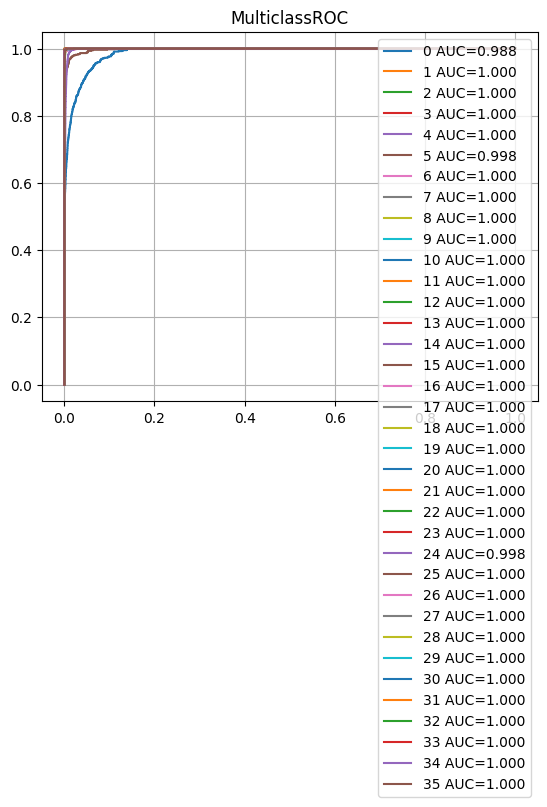

In [35]:
fig_, ax_ = roc.plot(score=True)

In [41]:
multi_accs = classification.MulticlassAccuracy(num_classes=36, average = 'none')
multi_accs(torch.from_numpy(preds), torch.from_numpy(actual))

tensor([0.2764, 0.9855, 0.7340, 0.9874, 0.9347, 0.8287, 0.9819, 0.9859, 0.9877,
        0.9818, 0.9923, 0.9895, 0.9878, 0.9737, 0.9923, 0.9906, 0.9702, 0.9866,
        0.9703, 0.9845, 0.9746, 0.9920, 0.9953, 0.9951, 0.9934, 0.9974, 0.9811,
        0.9975, 0.9951, 0.9913, 0.9972, 0.9768, 0.9890, 0.9935, 0.9964, 0.9965])

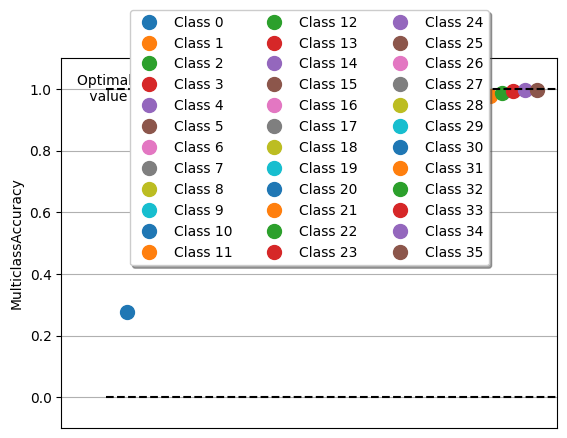

In [42]:
fig_, az_ = multi_accs.plot()

In [19]:
confmat = classification.MulticlassConfusionMatrix(num_classes=36)
confmat(torch.from_numpy(preds), torch.from_numpy(actual))

tensor([[ 161,    0,    0,  ...,    0,    0,    0],
        [   0,  792,    0,  ...,    0,    2,    1],
        [   0,    1,  483,  ...,    0,    2,  179],
        ...,
        [   0,    0,    0,  ...,  588,    1,    0],
        [   0,    0,    0,  ...,    0, 1099,    0],
        [   0,    0,    0,  ...,    0,    0,  603]])

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

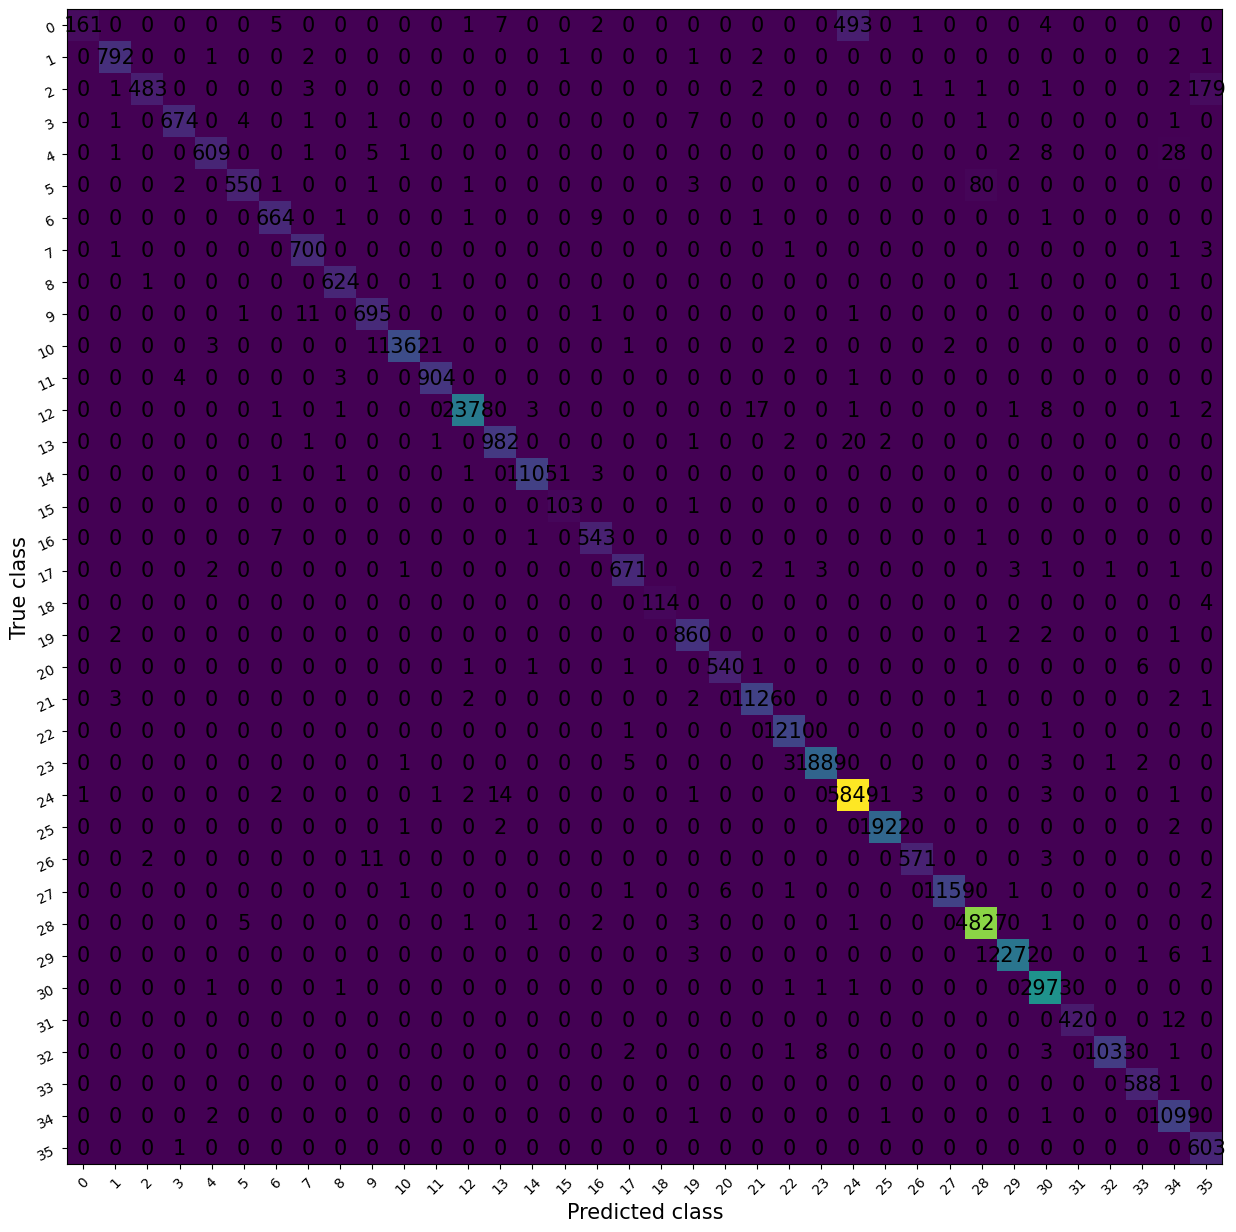

In [21]:
fig, a = plt.subplots(figsize=(15, 15))

confmat.plot(ax = a)

